# Function definitions

In [1]:
import mpmath as mp
import numpy as np
import cupy as cp
import scipy
import scipy.signal as ss
from mpmath import mpf, sin, cos, re, ellipf, ellipe
import matplotlib.pyplot as plt
#from .dist import lambda_p_Gauss

from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
from cupyx.scipy.ndimage.filters import convolve as cupy_conv

from numpy import exp, pi

def lambda_p_Gauss(z, x): 
    """
    The z derivative of a 2D Gaussian G(z,x)
    """
    sigmaz = 10E-6 
    sigmax = 10E-6
    return 1/(2*pi*sigmaz*sigmax)*exp(-x**2/2/sigmax**2)*exp(-z**2/2/sigmaz**2)*(-z/sigmaz**2)

def psi_s(z, x, beta):
    """
	2D longitudinal potential
    Eq. (23) from Ref[1] with no constant factor (e*beta**2/2/rho**2).
    Ref[1]: Y. Cai and Yuantao. Ding, PRAB 23, 014402 (2020)
    """
    z = float(z)
    x = float(x)
    try:
        out = (cos(2*alpha(z,x,beta)) - 1/(1+x)) / (kappa(z,x,beta) - beta*(1+x)*sin(2*alpha(z,x,beta)))
    except ZeroDivisionError:
        out = 0
        #print(f"Oops!  ZeroDivisionError at (z,x)= ({z:5.2f},{x:5.2f}). Returning 0.")
    return out

def psi_x(z, x, beta):
    """
    Eq.(24) from Ref[1] with argument zeta=0 and no constant factor e*beta**2/2/rho**2.
    """
    z = float(z)
    x = float(x)
    try:     
        T1 = 1/abs(x)/(1+x)*((2+2*x+x**2) *ellipf(alpha(z,x,beta),-4*(1+x)/x**2)  -  x**2*ellipe(alpha(z,x,beta),-4*(1+x)/x**2))
        D = kappa(z,x,beta)**2 - beta**2*(1+x)**2 *sin(2*alpha(z,x,beta))**2
        T2 = (kappa(z,x,beta)**2 - 2*beta**2*(1+x)**2 + beta**2*(1+x)*(2+2*x+x**2)*cos(2*alpha(z,x,beta)))/beta/(1+x)/D
        T3 = -kappa(z,x,beta) *sin(2*alpha(z,x,beta))/D
        T4 = kappa(z,x,beta) *beta**2 *(1+x) *sin(2*alpha(z,x,beta)) *cos(2*alpha(z,x,beta))/D
        T5 = 1/abs(x)*ellipf(alpha(z,x,beta),-4*(1+x)/x**2)   # psi_phi without e/rho**2 factor
        out = re( (T1 + T2 + T3 + T4) - 2/beta**2*T5 )
    except ZeroDivisionError:
        out = 0
        #print(f"Oops!  ZeroDivisionError at (z,x)= ({z:5.2f},{x:5.2f}). Returning 0.")
    return out

def nu(x, beta):   
    """
    Eq. (6) from Ref[1] (coeffient of alpha**2)
    """
    return 3*(1 - beta**2 - beta**2*x) / beta**2 / (1+x)
def eta(z, x, beta):
    """
	Eq. (6) from Ref[1] (coeffient of alpha)
	"""
    return -6*z / beta**2 / (1+x)
def zeta(z, x, beta):
    """
	Eq. (6) from Ref[1] (constant term)
	"""
    return 3*(4 *z**2 - beta**2 *x**2) / 4 / beta**2 / (1+x)
def Omega(z, x, beta):
    """
	Eq. (A3) from Ref[1]
	"""
    temp = eta(z,x,beta)**2/16 - zeta(z,x,beta) *nu(x,beta)/6 + nu(x,beta)**3 / 216
    return temp + ( temp**2 - ( zeta(z,x,beta)/3 + nu(x,beta)**2/36 )**3 )**(1/2)
def m(z, x, beta):
    """
	Eq. (A2) from Ref[1]
	"""
    return -nu(x,beta)/3 + ( zeta(z,x,beta)/3 + nu(x,beta)**2/36 ) *Omega(z,x,beta)**(-1/3) + Omega(z,x,beta)**(1/3)
def alpha(z, x, beta):
    """
	Eq. (A4) from Ref[1]
	"""
    if z<0: 
        out= 1/2*(-(2*m(z,x,beta))**(1/2) + ( -2*(m(z,x,beta) + nu(x,beta)) + 2*eta(z,x,beta)*(2*m(z,x,beta))**(-1/2) )**(1/2))
    else: 
        out= 1/2*( (2*m(z,x,beta))**(1/2) + ( -2*(m(z,x,beta) + nu(x,beta)) - 2*eta(z,x,beta)*(2*m(z,x,beta))**(-1/2) )**(1/2))
    return re(out)
def kappa(z,x,beta):
    """
	Eq. (13) from Ref[1] with argumaent zeta = 0
	"""
    return ( x**2 + 4*(1+x) *sin(alpha(z,x,beta))**2 )**(1/2)


def make_2dgrid(func,zmin,zmax,dz, xmin, xmax, dx):
    """
    Make a 2D grid of a function
    """
    zvec = np.arange(zmin, zmax, dz)
    xvec = np.arange(xmin, xmax, dx)
    list2d= [[func(i,j) for j in xvec] for i in zvec] 
    return np.array(list2d,dtype=float)
    


def Wx(gamma,rho,sigmaz,sigmax,dz,dx):
    """
    Apply 2D convolution to compute the transverse wake Wx on a grid 
    Also returns the zvec and xvec which define the grid
    
    Still needs to improve the convolution step
    """
    beta = (1-1/gamma**2)**(1/2)
    zvec = np.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = np.arange(-5*sigmax, 5*sigmax, dx)
    lambdap_list = [[lambda_p_Gauss(i,j) for j in xvec] for i in zvec] 
    lambdap_grid = np.array(lambdap_list,dtype=float)
    zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
    psi_x_list = [[psi_x(i/2/rho,j,beta) for j in xvec2] for i in zvec2]   
    psi_x_grid = np.array(psi_x_list,dtype=float)
    conv_x = ss.convolve2d(lambdap_grid, psi_x_grid, mode='same', boundary='fill', fillvalue=0)
    WxConv = beta**2/rho*conv_x*(dz)*(dx)
    return zvec, xvec, WxConv

In [65]:
def Ws(gamma,rho,sigmaz,sigmax,dz,dx,method='oa'):
    """
    Apply 2D convolution to compute the longitudinal wake Ws on a grid 
    Also returns the zvec and xvec which define the grid
    
    Still needs to improve the convolution step
    """
    beta = (1-1/gamma**2)**(1/2)
    xp = np
    if method == 'cupy':
        xp = cp
    elif method == 'oa':
        conv_method = oaconvolve
    elif method == 'fft':
        conv_method = fftconvolve
    elif method == '2d':
        conv_method = convolve2d
    else:
        print('Invalid convolution method specified!!')
    
    # Creating the grid of the z-derivative of the bunch distribution
    zvec = np.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = np.arange(-5*sigmax, 5*sigmax, dx)
    lambdap_list = [[lambda_p_Gauss(i,j) for j in xvec] for i in zvec] 
    lambdap_grid = xp.array(lambdap_list,dtype=float)
    
    # Creating the grid of the potential 
    zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
    psi_s_list = [[psi_s(i/2/rho,j,beta) for j in xvec2] for i in zvec2]   
    psi_s_grid = xp.array(psi_s_list,dtype=float)
    
    # Convolution
    if method == 'cupy':
        conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant', cval=0.0)
    else:
        #conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same', boundary='fill', fillvalue=0)
        conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same')
        
    WsConv = beta**2/rho*conv_s*(dz)*(dx)
   
    return zvec, xvec, WsConv

# Testing

In [83]:
gamma = 500
rho = 1
sigmax = 10E-6
sigmaz = 10E-6

# Adjust the step size here
# Small steps might greatly increase computation time...
dz = 0.1*sigmaz
dx = 0.1*sigmax

## single run testing

In [86]:
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'cupy')

In [85]:
# find the index for which zvec[index] is closest to zero
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] 
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

print(WsConv[zix_min,xix_min])
WsConv.__class__

-2573180.4757994055


cupy.core.core.ndarray

In [87]:
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'oa')

In [89]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

-2677061.3108137683


numpy.ndarray

In [90]:
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'fft')

In [91]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

-2677061.3108137683


numpy.ndarray

## timing test

In [47]:
%%timeit -n 3 -r 4 
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'cupy')

26.1 s ± 815 ms per loop (mean ± std. dev. of 4 runs, 3 loops each)


In [48]:
%%timeit -n 3 -r 4 
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'oa')

25.5 s ± 282 ms per loop (mean ± std. dev. of 4 runs, 3 loops each)


# Below is Scratch for now

In [39]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

WsConv[zix_min,xix_min] # returns Ws(~0,~0)

-2637000.1166977924

In [56]:
np.save('test',WsConv)
np.load('test.npy');

## Vectorize from Chris

In [37]:
@np.vectorize
def mf(a,b):
    return lambda_p_Gauss(a,b)
vf = np.vectorize(mf)
vf([[0.00001,0.00002],[0.00003,0.00004]] , [[0.00001,0.00002],[0.0003,0.00004]])

array([[array(mpf('-58549831524319.141'), dtype=object),
        array(mpf('-5830048930056.3857'), dtype=object)],
       [array(mpf('-1.959292884786357e-183'), dtype=object),
        array(mpf('-71642117.313120723'), dtype=object)]], dtype=object)

Text(0, 0.5, 'Ws$(10^6 m^{-2})$')

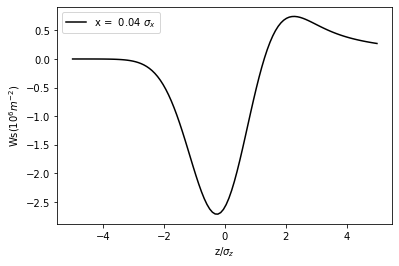

In [58]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

plt.plot(zvec/sigmaz, WsConv[:,int(xix_min)]/1e6, '-', color='black', label=f"x = {xvec[xix_min]/sigmax:5.2f} $\sigma_x$");
plt.legend(loc='upper left')
plt.xlabel('z/$\sigma_z$')
plt.ylabel('Ws$(10^6 m^{-2})$')

In [ ]:
%timeit -n 3 -r 4 ndimage.convolve(a, k, mode='constant', cval=0.0)
%timeit -n 3 -r 4 signal.convolve2d(a, k, mode='same')
%timeit -n 3 -r 4 fftconvolve(a, k, mode='same')
%timeit -n 3 -r 4 oaconvolve(a, k, mode='same')

a = cp.random.randint(5, size=(N, N))
k = cp.random.randint(5, size=(2*N, 2*N))
%timeit -n 3 -r 4 filters.convolve(a, k, mode='constant', cval=0.0)

In [20]:
from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
a = np.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = np.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(conv(a, k, mode='constant', cval=0.0))

[[11 21 14 11]
 [22 26 23 14]
 [15 23 14  7]
 [12 14  7  0]]


In [23]:
a = cp.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = cp.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(cupy_conv(a, k, mode='constant', cval=0.0))

[[11 21 14 11]
 [22 26 23 14]
 [15 23 14  7]
 [12 14  7  0]]
